# Ordering a data takeout
## Sync overview

Feature layers includes a `Sync` capability, which when enabled, allows client applications to take feature layers offline, perform edits and sync it back to the layer. 

When you checkout some features and store it offline in the client, you call that a `replica`. The `FeatureLayerCollection` class under the `features` module allows users to create and work with replicas. 

The workflow of using sync involves these three operations:
- Create replica
- Synchronize replica
- Unregister replica

To learn more about this feature, refer to the [documentation here](http://resources.arcgis.com/en/help/arcgis-rest-api/index.html#//02r300000112000000)

### Checking out data from feature layers using replicas

To create a replica, we need a feature layer that is sync enabled. `FeatureLayer.syncEnabled` to verify that. Further the `syncCapabilities` property returns a dictionary with fine grained sync capabilities.

In [1]:
# connect to a GIS
from arcgis.gis import GIS
import arcgis.features
gis = GIS() # connect to www.arcgis.com anonymously. 
            # we will use a public sync enabled feature layer

Create a `FeatureLayerCollection` object from a feature service

In [2]:
url = 'https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer/'
wildfire_flc = arcgis.features.FeatureLayerCollection(url, gis)

In [3]:
type(wildfire_flc)

arcgis.features.layer.FeatureLayerCollection

### Verify if sync is enabled

Accessing the `layers` property on a `FeatureLayerCollection` returns a list of `FeatureLayer` objects. We can create a replica of one of these or all of these layers

In [4]:
wildfire_flc.layers

[<FeatureLayer url:"https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer//0">,
 <FeatureLayer url:"https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer//1">,
 <FeatureLayer url:"https://sampleserver6.arcgisonline.com/arcgis/rest/services/Sync/WildfireSync/FeatureServer//2">]

In [5]:
# query syncEnabled property to verify is sync is enabled
wildfire_flc.properties.syncEnabled

True

In [6]:
# query the syncCapabilities property to view fine grained capabilities
wildfire_flc.properties.syncCapabilities

{
  "supportsRegisteringExistingData": true,
  "supportsPerReplicaSync": false,
  "supportsAttachmentsSyncDirection": true,
  "supportsRollbackOnFailure": false,
  "supportsAsync": true,
  "supportsSyncDirectionControl": true,
  "supportsPerLayerSync": true,
  "supportsSyncModelNone": true
}

### List existing replicas

`FeatureLayerCollection.replicas` returns you a `SyncManager` object. You would work with this manager object for all your sync workflows.

Call `SyncManager.get_list()` method to get list of existing replicas.

In [7]:
replica_list = wildfire_flc.replicas.get_list()
len(replica_list)

5741

As you can see, there are plenty of replicas on this layer. Let us view one of it

In [8]:
replica_list[0]

{'replicaID': '8F0BAFB1-7CD2-4FA3-85C6-92B13F1E774D',
 'replicaName': 'Ags_Fs_1477025582337'}

### Create a replica
 Call `SyncManager.create()` method to creat a new replica.
 
  - For 2 way sync between client and server, the feature layer needs `Sync` capability.
  - For checking out (downloading) data from server, you need `Extract` capability.

In [9]:
# list all capabilities
wildfire_flc.properties.capabilities

'Create,Delete,Query,Sync,Update,Uploads,Editing'

This layer has disabled 'Extract'. Hence let us search for a different layer

In [15]:
from getpass import getpass
password = getpass()
portal_gis = GIS("http://esriwebgis.webgistesting.net/portal", "atma.mani", password)
search_result = portal_gis.content.search("USA states rivers cities", "Feature Layer")

········


<Item title:"USA states rivers cities" type:Feature Service owner:atma.mani>
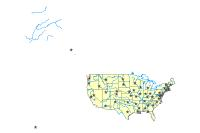

In [16]:
search_result[0]

Let us create a `FeatureLayerCollection` object from this item

In [19]:
states_flc = arcgis.features.FeatureLayerCollection.fromitem(search_result[0])
type(states_flc)

arcgis.features.layer.FeatureLayerCollection

#### Verify Extract capability

In [18]:
states_flc.properties.capabilities

'Create,Delete,Query,Sync,Update,Uploads,Editing'

Let us turn on the Extract capability by adding to the definition

In [22]:
existing_cap = states_flc.properties.capabilities
states_flc.manager.update_definition({'capabilities':existing_cap + ',Extract'})

{'success': True}

In [23]:
states_flc._refresh()
states_flc.properties.capabilities

'Create,Delete,Query,Sync,Update,Uploads,Editing,Extract'

This is a suitable feature layer, let us extract the data into a file geodatabase and store it in local file system

In [ ]:
ports_flc = arcgis.features.FeatureLayerCollection.fromitem(sr[0])

In [25]:
replica1 = states_flc.replicas.create(replica_name = 'arcgis_python_api_2',
                                    layers='0',
                                    data_format='filegdb',
                                    out_path = 'D:\\Temp')
replica1

{'statusUrl': 'http://ESRIwebgis.webgistesting.net/server/rest/services/Hosted/WFL_allcapabilities/FeatureServer/jobs/j3427edd579874da2adce29a4db8d2c50'}

## Removing replicas

The sync operation is expensive on the resources of your web GIS. Hence, it is a good maintenance practice to remove unnecessary replicas. An ArcGIS admin could use the ArcGIS Python API to script and automate the process of scanning all feature layers and removing stale replicas on each of them.

A replica can be removed by calling the `unregister()` method and passing the id of a replica that needs to be removed.

In [ ]:
# Let us query all the replicas registered on the ports feature layer from before
replica_list = ports_flc.replicas.get_list()

In [ ]:
for r in replica_list:
    print(r)

{'replicaName': 'SDS_FS', 'replicaID': '86E9D1D7-96FF-4B40-A366-DC9A9AAB6923'}
{'replicaName': 'SDS_FS_1481235956703', 'replicaID': '3B07459D-A23F-47D5-8E76-F3835E883A9D'}
{'replicaName': 'SDS_FS_1481236016125', 'replicaID': '662B83DA-6626-4BD1-8FAE-1A171EA5230B'}
{'replicaName': 'SDS_FS_1481236054393', 'replicaID': '38BAF9F8-34FE-4153-AE9C-2756992A49F5'}
{'replicaName': 'SDS_FS_1481236093401', 'replicaID': '3CB074DB-BA87-4E05-8235-F981FE5C601E'}


There are more than a few. I only want to remove the replicas that were registered 10 minutes ago. But, your search criteria could be any other. 

We will loop through each of the replicas returned and use the `get()` method to get detailed information about these replicas and look a `creationDate` property.

Before looping, let us take a deeper look at one of these replicas by calling the `get()` method:

In [ ]:
replica1 = ports_flc.replicas.get('86E9D1D7-96FF-4B40-A366-DC9A9AAB6923')
replica1

{'attachmentsSyncDirection': 'bidirectional',
 'creationDate': 1481235395998,
 'geometry': {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
  'xmax': -12351726.0067822,
  'xmin': -18249471.330872223,
  'ymax': 7382319.928103409,
  'ymin': 341526.2431555473},
 'lastSyncDate': 1481235395998,
 'layerServerGens': [{'id': 0, 'serverGen': 1481235395998}],
 'layers': [{'id': 0,
   'includeRelated': True,
   'queryOption': 'useFilter',
   'useGeometry': True,
   'where': ''}],
 'replicaID': '86E9D1D7-96FF-4B40-A366-DC9A9AAB6923',
 'replicaName': 'SDS_FS',
 'replicaOwner': 'arcgis_python_api',
 'returnsAttachments': True,
 'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'spatialRel': 'esriSpatialRelIntersects',
 'syncModel': 'perLayer',
 'targetType': 'client'}

The `creationDate` key is retured as unix epoch time. We need to convert it to local time for processing:

In [ ]:
import time
time.localtime(replica1['creationDate']/1000) #dividing by 1000 to convert micro seconds to seconds

time.struct_time(tm_year=2016, tm_mon=12, tm_mday=8, tm_hour=14, tm_min=16, tm_sec=35, tm_wday=3, tm_yday=343, tm_isdst=0)

To determine those replicas that were created 10 mins earlier, let us create an epoch timestamp for 10 mins before now and find those replicas whose time stamps are lower than this

In [ ]:
ten_min_earlier_epoch = time.time() - 10
ten_min_earlier_epoch

1481238022.105653

In [ ]:
import time
removal_list = []
for r in replica_list:
    temp_r = ports_flc.replicas.get(r['replicaID'])
    temp_dict = {'replica_id': r['replicaID'],
                'creationDate':temp_r['creationDate']/1000}
    
    #check
    if temp_dict['creationDate'] < ten_min_earlier_epoch:
        removal_list.append(temp_dict)
        print(temp_dict)

{'creationDate': 1481235395.998, 'replica_id': '86E9D1D7-96FF-4B40-A366-DC9A9AAB6923'}
{'creationDate': 1481235955.848, 'replica_id': '3B07459D-A23F-47D5-8E76-F3835E883A9D'}
{'creationDate': 1481236015.278, 'replica_id': '662B83DA-6626-4BD1-8FAE-1A171EA5230B'}
{'creationDate': 1481236053.455, 'replica_id': '38BAF9F8-34FE-4153-AE9C-2756992A49F5'}
{'creationDate': 1481236092.515, 'replica_id': '3CB074DB-BA87-4E05-8235-F981FE5C601E'}


Let us loop through each of these replicas and remove them using the `unregister()` method:

In [ ]:
for r in removal_list:
    result = ports_flc.replicas.unregister(r['replica_id'])
    print(result)

{'success': True}
{'success': True}
{'success': True}
{'success': True}
{'success': True}
